# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, accuracy_score
import time
import pickle
import os

import warnings
warnings.filterwarnings('ignore')

# Load and Encode Activity Labels

In [2]:
columns = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)',
           'Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)', 'Activity_Label']
df = pd.read_csv("Scaled_Combined_Active_Gyro_Accel_Cleaned.csv", usecols=columns)

LE = LabelEncoder()
df['Activity_Label'] = LE.fit_transform(df['Activity_Label'])

# Display DataFrame

In [3]:
df

,Accel X (g),Accel Y (g),Accel Z (g),Gyro X (°/s),Gyro Y (°/s),Gyro Z (°/s),Activity_Label
0,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
1,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
2,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
3,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
4,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
...,...,...,...,...,...,...,...
230160,8.446744,-4.716577,3.725378,-0.808786,0.274889,-0.142942,9
230161,8.446744,-4.716577,3.725378,-0.808786,0.274889,-0.142942,9
230162,8.446744,-4.716577,3.725378,-0.808786,0.274889,-0.142942,9
230163,8.446744,-4.716577,3.725378,-0.808786,0.274889,-0.142942,9


# Define Features and Target Variables

In [4]:
columns = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)',
           'Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)', 'Activity_Label']
df = pd.read_csv("Scaled_Combined_Active_Gyro_Accel_Cleaned.csv", usecols=columns)

PredictorCol = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)',
                'Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)']
TargetCol = 'Activity_Label'

X = df[PredictorCol].values
y = df[TargetCol].values

# Train-Test Split with Stratification

In [5]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=15, 
    stratify=y  
)

# Train and Evaluate Random Forest Classifier with Cross-Validation

===== Training and Inference Times =====
Training Time: 14.7455 seconds
Inference Time (for test set): 0.6074 seconds

===== Stratified Cross-Validation Results =====
Stratified CV Accuracy (mean ± std): 0.9576 ± 0.0027
Training Set Accuracy: 0.9586
Test Set Accuracy: 0.9579

===== Classification Report =====
                             precision    recall  f1-score   support

               Chair Squats       0.94      0.97      0.95      5553
   Light Stationary Cycling       0.98      0.98      0.98      6509
          Marching in Place       0.98      0.98      0.98     10967
        Seated Boxing Hooks       1.00      0.94      0.97      7735
      Seated Leg Extensions       0.78      0.99      0.87      5549
Seated Medicine Ball Twists       0.99      0.94      0.96      5571
          Seated Side Bends       0.97      0.95      0.96      5566
              Side-Stepping       0.98      0.98      0.98      5511
  Standing Heel-to-Toe Walk       0.97      0.96      0.97      796

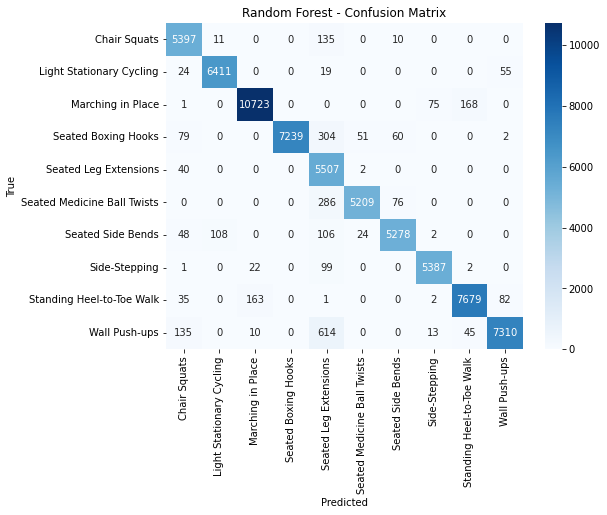

In [6]:
# Initialize the RandomForestClassifier with the best hyperparameters found
best_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

# ===================== Stratified K-Fold Cross-Validation =====================

# Perform Stratified 10-fold cross-validation on the training data
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf_model, X_train_sm, y_train_sm, cv=skf, scoring='accuracy')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

# ============================ Train the Model ============================

# Train the model on the entire training set
start_train_time = time.time()
best_rf_model.fit(X_train_sm, y_train_sm)
train_time = time.time() - start_train_time

# ===================== Predictions on Test Data =====================

# Predict on the test data using the trained Random Forest model
start_infer_time = time.time()
y_pred_rf = best_rf_model.predict(X_test_sm)
infer_time = time.time() - start_infer_time

# ========================== Calculate Accuracy =========================

# Accuracy on training data
train_accuracy_rf = accuracy_score(y_train_sm, best_rf_model.predict(X_train_sm))

# Accuracy on test data
test_accuracy_rf = accuracy_score(y_test_sm, y_pred_rf)

# ===================== Print Stratified Cross-Validation and Accuracy Results =====================

print("===== Training and Inference Times =====")
print(f"Training Time: {train_time:.4f} seconds")
print(f"Inference Time (for test set): {infer_time:.4f} seconds")

print("\n===== Stratified Cross-Validation Results =====")
print(f"Stratified CV Accuracy (mean ± std): {mean_cv_score:.4f} ± {std_cv_score:.4f}")
print(f"Training Set Accuracy: {train_accuracy_rf:.4f}")
print(f"Test Set Accuracy: {test_accuracy_rf:.4f}")

# ========================= Classification Report ========================

print("\n===== Classification Report =====")
print(classification_report(y_test_sm, y_pred_rf))

# ========================= Confusion Matrix =========================

# Compute the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_sm, y_pred_rf)

# Display confusion matrix
df_conf_matrix_rf = pd.DataFrame(conf_matrix_rf, index=LE.classes_, columns=LE.classes_)
print("\n===== Confusion Matrix on Test Set =====")
print(df_conf_matrix_rf)

# ======================= Plot Confusion Matrix ========================

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=LE.classes_, yticklabels=LE.classes_)
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save Trained Random Forest Model

In [7]:
import pickle

with open("RF_HAR_Combined_Active_Gyro_Accel.pkl", "wb") as file:
    pickle.dump(best_rf_model, file)

print("Random Forest model for HAR with Combined Active Gyroscope and Accelerometer has been successfully saved to 'RF_HAR_Combined_Active_Gyro_Accel.pkl'")

Random Forest model for HAR with Combined Active Gyroscope and Accelerometer has been successfully saved to 'RF_HAR_Combined_Active_Gyro_Accel.pkl'
